In [1]:
import random
from matplotlib import pyplot as plt
from math import atan, pi, radians

In [2]:
# Define a class for our points
class Point:
    def __init__(self, limit=100,xpoint=None, ypoint=None):
        self.xpoint = self.get_random(limit) if not xpoint else xpoint
        self.ypoint = self.get_random(limit) if not ypoint else ypoint

    def get_random(self, limit):
        return random.randrange(1, limit)
    
    # limit exists only to minimize the probability of ending up with collinear points
    # It's not needed, but simplifies the problem

In [3]:
# Function for generating coordiantes or preparing existing
# coordiantes for use by the algorithm
def generatePoints(random=0, coordinates=[]):
    points = []
    if random:
        # Generate n random coordinates
        points = [Point(limit=random*100) for x in range(random)] # Number of options to choose from (limit) = random * 100
    elif coordinates:
        # Generate coordiantes with known values from the coordinates argument passed
        # Coordinates passed must be in the format [[x,y], [x,y], [x,y], ...]
        points = [Point(xpoint=c[0], ypoint=c[1]) for c in coordinates]
    else:
        print("Specify either random (Integer) or coordinates [[x,y], [x,y], [x,y], ...]")

    return points

In [4]:
# Find the point with the lowest x coordinate (left most)
def findReferencePoint(points):
    ref_point = None
    for p in points:
        if not ref_point:
            ref_point = p
        elif p.xpoint < ref_point.xpoint:
            ref_point = p

    return ref_point

In [5]:
# Calculate Angles between ref point and each of the other points
def calculateAngle(ref_point, point):
    angle = 0
    # 90 and 180 degrees means the points are collinear
    # When the points share y coordinates, we will have a division by zero problem
    # In this case, we already know the angle is 90 degrees or half of pi
    if ref_point.ypoint == point.ypoint:
        angle = pi/2
    elif ref_point.xpoint == point.xpoint:
        # When the points share x coordinates, the angle between them is 180 degrees (pi radians)
        angle = pi
    else:
        # Otherwise we calculate the angle from trig identities
        # Tan = O/A -> Tan inverse (atan) gives us the angle
        angle = atan((abs(ref_point.xpoint - point.xpoint))/(abs(ref_point.ypoint - point.ypoint)))

    # All angles should be checked counterclockwise
    if ref_point.ypoint < point.ypoint:
        # pi radians = 180 degrees
        angle = pi - angle

    return angle

def sortPoints(ref_point, points):
    points_ordered_by_angle = []

    for p in points:
        if ref_point != p:
            angle = calculateAngle(ref_point, p)
            points_ordered_by_angle.append({"angle": angle, "point": p})

    # Sort the points by angle
    points_ordered_by_angle = sorted(points_ordered_by_angle, key=lambda d: d['angle'])

    return points_ordered_by_angle

In [6]:
def generateConvexHull(ref_point, ordered_points):
    results = [ref_point, ordered_points[0]["point"]]
    
    for i in ordered_points[1:]:
        results.append(i["point"]) # Put the current point in the stack -> It may be part of the convex hull

        signed_area = 0

        while True:# This is here to help us make sure we only have positive signed areas
            # A -> Vector from 3rd last point to 2nd last point
            A = (results[-3].xpoint - results[-2].xpoint, results[-3].ypoint - results[-2].ypoint)
            # B -> Vector from 2nd last point to current point
            B = (results[-2].xpoint - results[-1].xpoint, results[-2].ypoint - results[-1].ypoint)
        
            # The cross product of vectors A and B (A X B) is a vector C perpendicular to both A and B
            # and with magnitude equal to the area of the parallelogram spanned by vectors A and B.
            # A positive area means the three vectors, A, B and C form a right hand system.
            # The area is given by the determinant of 
            # |  i  j  k |
            # | ax ay az |
            # | bx by bz |
            # = (aybz - byaz) + (axbz - bxaz) + (axby - bxay)
            # Since we are working with 2D, all z terms will be 0
            # => |A X B| = axby - bxay
            signed_area = A[0] * B[1] - B[0] * A[1]
        
            # We only keep points that make CCW turns wrt to last two points
            # The cross product is positive if the turn is CCW, negative otherwise
            if signed_area < 0:
                results.pop(-2)
            else:
                break

        # print([(x.xpoint, x.ypoint) for x in results])
        # print(A, B, signed_area)

    return results

In [7]:
# The functions below will help us run tests to confirm
# algorithm is working as expected

# Run this to test the correctness of the reference point
# Returns True if test is passed
def testRefpoint(ref_point):
    return ref_point.xpoint == -5 and ref_point.ypoint == -3

# Run this function to test whether ordering of points is correct
# Returns True if ordering is correct, False otherwise
def testOrdering(ordered_points):
    correct_ordering = [(3,-4),(2,-3),(-2,-2),(3,3),(4,5),(2,7),(-1,4),(-3,2), (-2,7)]
    given_ordering = [(i["point"].xpoint, i["point"].ypoint) for i in ordered_points]
    return correct_ordering == given_ordering

def runTests():
    print("Generating test coordinates")
    coordinates = [
        [-2, 7], [-3, 2], [-2, -2], [-1, 4],
        [3, 3], [2, 7], [-5, -3], [3, -4],
        [2,-3], [4,5]
    ]

    points = generatePoints(coordinates=coordinates)

    ref_point = findReferencePoint(points)

    # Test if ref_point is correct
    print("Ref point: PASSED") if testRefpoint(ref_point) else print("Ref point: FAILED")

    ordered_points = sortPoints(ref_point, points)
    print("Ordering: PASSED") if testOrdering(ordered_points) else print("Ordering: FAILED")

    convex_hull = generateConvexHull(ref_point, ordered_points)
    # Test if convex hull is correct

    results = {"points": points, "convex_hull": convex_hull}

    return results


# Display the resulting points and convex hull
def plotResults(points, convex_hull):
    xpoints = [p.xpoint for p in points]
    ypoints = [p.ypoint for p in points]

    # PLOT 1
    # plt.plot(xpoints, ypoints, 'o')

    # PLOT 2
    plt.plot(xpoints, ypoints, 'o')
    plt.axis('off')

    # Join the points using a line, starting with the top most 
    for r in range(0, len(convex_hull)):
        p = convex_hull[r]
        q = convex_hull[r+1] if r < len(convex_hull) - 1 else convex_hull[0]
    
        plt.plot([p.xpoint, q.xpoint],[p.ypoint, q.ypoint],'ro-')
    
    plt.show()

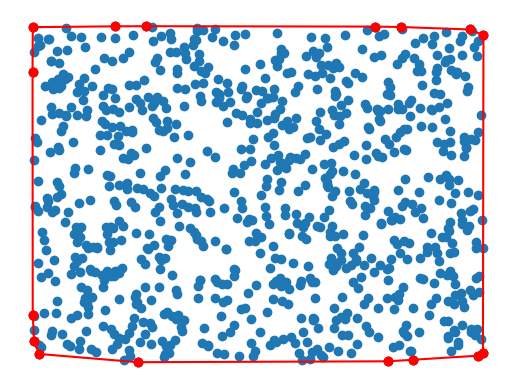

In [8]:
def findConvexHull(random=0, coordinates=[]):
    if random:
        points = generatePoints(random=random)
    elif coordinates:
        points = generatePoints(coordinates=coordinates)
    else:
        print("Specify either coordinates or number of random points")

    ref_point = findReferencePoint(points)

    ordered_points = sortPoints(ref_point, points)

    convex_hull = generateConvexHull(ref_point, ordered_points)
    # Test if convex hull is correct

    results = {"points": points, "convex_hull": convex_hull}

    return results


# TESTS
# results = runTests()

# SPECIFIED COORDINATES
# coordinates = [
#     [-2, 7], [-3, 2], [-2, -2], [-1, 4],
#     [3, 3], [2, 7], [-5, -3], [3, -4],
#     [2,-3], [4,5]
# ]
# results = findConvexHull(coordinates=coordinates)

# RANDOM COORDINATES
results = findConvexHull(random=897)


plotResults(results["points"], results["convex_hull"])